In [677]:
!pip install dagshub mlflow

In [678]:
import dagshub
dagshub.init(repo_owner='lkhok22', repo_name='ML-hw1', mlflow=True)

Initialized MLflow to track repo "lkhok22/ML-hw1"

Repository lkhok22/ML-hw1 initialized!

In [679]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [680]:
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

In [681]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)

In [682]:
df.shape

(1460, 81)

In [683]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [684]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [685]:
X_train.shape, X_test.shape

((1168, 80), (292, 80))

In [686]:
train_ids = X_train.pop('Id')
test_ids = X_test.pop('Id')

In [687]:
def handle_nulls(df: pd.DataFrame) -> pd.DataFrame:
    # 1. Drop columns with 80% or more missing values
    threshold = 0.8
    null_fraction = df.isnull().mean()
    cols_to_drop = null_fraction[null_fraction >= threshold].index
    df.drop(columns=cols_to_drop, inplace=True)

    # 2. Separate numerical and categorical columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categoric_cols = df.select_dtypes(include=['object', 'category']).columns

    # 3. Fill numeric NaNs with 0
    df.loc[:, numeric_cols] = df[numeric_cols].fillna(0)

    # 4. Fill categorical NaNs with "NO"
    df.loc[:, categoric_cols] = df[categoric_cols].fillna("NO")

    return df

In [688]:
X_train_cleaned = handle_nulls(X_train.copy())
X_test_cleaned = handle_nulls(X_test.copy())

In [689]:
cat_cols = [col for col in X_train_cleaned.columns if X_train_cleaned[col].dtype == 'object']
num_cols = [col for col in X_train_cleaned.columns if X_train_cleaned[col].dtype != 'object']

print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numerical columns ({len(num_cols)}): {num_cols}")

Categorical columns (39): ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
Numerical columns (36): ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 

In [690]:
s = X_train_cleaned[cat_cols].nunique()

In [691]:
s

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          7
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          5
BsmtCond          5
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

In [692]:
threshold = 3

woe_columns = list(s[s > 3].index)
one_hot_columns = list(s[s <= 3].index)

In [693]:
X_train_cleaned[woe_columns].mode().T[0].to_dict()

{'MSZoning': 'RL',
 'LotShape': 'Reg',
 'LandContour': 'Lvl',
 'LotConfig': 'Inside',
 'Neighborhood': 'NAmes',
 'Condition1': 'Norm',
 'Condition2': 'Norm',
 'BldgType': '1Fam',
 'HouseStyle': '1Story',
 'RoofStyle': 'Gable',
 'RoofMatl': 'CompShg',
 'Exterior1st': 'VinylSd',
 'Exterior2nd': 'VinylSd',
 'MasVnrType': 'NO',
 'ExterQual': 'TA',
 'ExterCond': 'TA',
 'Foundation': 'PConc',
 'BsmtQual': 'TA',
 'BsmtCond': 'TA',
 'BsmtExposure': 'No',
 'BsmtFinType1': 'Unf',
 'BsmtFinType2': 'Unf',
 'Heating': 'GasA',
 'HeatingQC': 'Ex',
 'Electrical': 'SBrkr',
 'KitchenQual': 'TA',
 'Functional': 'Typ',
 'FireplaceQu': 'NO',
 'GarageType': 'Attchd',
 'GarageFinish': 'Unf',
 'GarageQual': 'TA',
 'GarageCond': 'TA',
 'SaleType': 'WD',
 'SaleCondition': 'Normal'}

In [694]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, woe_columns, one_hot_columns):
        self.woe_columns = woe_columns # Columns Which Should Be Preprocessed Using WOE
        self.one_hot_columns = one_hot_columns # Columns Which Should Be Preprocessed Using One Hot Encoder

    def fit(self, X, y):
        # Generate Fill Na Values Just in Case
        self.woe_columns_fill_na = X[woe_columns].mode().T[0].to_dict()
        
        df_woe = X.copy()
        target_col = 'target'
        df_woe[target_col] = y

        woe_mappings = {}
        iv_values = {}
        
        for col in self.woe_columns:
            print(f"Processing {col}...")
            
            groups = df_woe.groupby([col])[target_col].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
            
            groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
            groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()
            
            groups['woe'] = np.log(groups['prop_pos'] / groups['prop_neg'])
            groups['iv'] = (groups['prop_pos'] - groups['prop_neg']) * groups['woe']
            
            groups.replace([np.inf, -np.inf], 0, inplace=True)
            groups.fillna(0, inplace=True)
            
            woe_dict = groups['woe'].to_dict()
            iv = groups['iv'].sum()
            
            woe_mappings[col] = woe_dict
            iv_values[col] = iv

        self.woe_mappings = woe_mappings
        self.iv_values = iv_values

        return self


    def transform(self, X):
        X_transformed = X.copy()

        # Preprocess WOE Columns
        print("***")
        print("Preprocessing WOE Columns")
        for col in self.woe_columns:
            X_transformed[f'{col}_woe'] = X_transformed[col].map(self.woe_mappings[col])
            X_transformed.drop(columns=col, inplace=True)

        print("Preprocessing One Hot Columns")
        X_transformed = pd.get_dummies(X_transformed, columns=self.one_hot_columns, drop_first=True, dummy_na=True, dtype=int)

        print("Check Nans")
        n = X_transformed.isna().mean()

        na_cols = list(n[n > 0].index)

        print(na_cols)

        for col in na_cols:
            name, pr = col.split("_")
            if pr != "woe":
                print("Error Related to Nans")

            dic = self.woe_columns_fill_na
            mappings = self.woe_mappings
            X_transformed[col] = X_transformed[col].fillna(mappings[name][dic[name]])

            print(col, name, pr, dic[name], mappings[name][dic[name]])
            
        return X_transformed

In [695]:
preprocessor = CustomPreprocessor(woe_columns=woe_columns, one_hot_columns=one_hot_columns)

In [696]:
X_train_t = preprocessor.fit_transform(X_train_cleaned, y_train)

Processing MSZoning...
Processing LotShape...
Processing LandContour...
Processing LotConfig...
Processing Neighborhood...
Processing Condition1...
Processing Condition2...
Processing BldgType...
Processing HouseStyle...
Processing RoofStyle...
Processing RoofMatl...
Processing Exterior1st...
Processing Exterior2nd...
Processing MasVnrType...
Processing ExterQual...
Processing ExterCond...
Processing Foundation...
Processing BsmtQual...
Processing BsmtCond...
Processing BsmtExposure...
Processing BsmtFinType1...
Processing BsmtFinType2...
Processing Heating...
Processing HeatingQC...
Processing Electrical...
Processing KitchenQual...
Processing Functional...
Processing FireplaceQu...
Processing GarageType...
Processing GarageFinish...
Processing GarageQual...
Processing GarageCond...
Processing SaleType...
Processing SaleCondition...
***
Preprocessing WOE Columns
Preprocessing One Hot Columns
Check Nans
[]


In [697]:
X_train_t.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_woe,LotShape_woe,LandContour_woe,LotConfig_woe,Neighborhood_woe,Condition1_woe,Condition2_woe,BldgType_woe,HouseStyle_woe,RoofStyle_woe,RoofMatl_woe,Exterior1st_woe,Exterior2nd_woe,MasVnrType_woe,ExterQual_woe,ExterCond_woe,Foundation_woe,BsmtQual_woe,BsmtCond_woe,BsmtExposure_woe,BsmtFinType1_woe,BsmtFinType2_woe,Heating_woe,HeatingQC_woe,Electrical_woe,KitchenQual_woe,Functional_woe,FireplaceQu_woe,GarageType_woe,GarageFinish_woe,GarageQual_woe,GarageCond_woe,SaleType_woe,SaleCondition_woe,Street_Pave,Street_nan,Utilities_NoSeWa,Utilities_nan,LandSlope_Mod,LandSlope_Sev,LandSlope_nan,CentralAir_Y,CentralAir_nan,PavedDrive_P,PavedDrive_Y,PavedDrive_nan
254,20,70.0,8400,5,6,1957,1957,0.0,922,0,392,1314,1314,0,0,1314,1,0,1,0,3,1,5,0,1957.0,1,294,250,0,0,0,0,0,0,6,2010,-2.576594e-07,4.984725e-07,2.497580e-08,9.208937e-08,1.272474e-06,-9.535265e-08,-1.462012e-09,-1.389329e-07,1.334230e-07,3.046700e-07,1.978151e-08,1.180022e-06,1.147331e-06,7.868172e-07,0.000001,4.481936e-07,0.000001,1.515354e-06,-8.535108e-08,4.949177e-07,1.231387e-06,-9.680952e-08,-3.674229e-08,1.439573e-06,-1.623822e-07,1.525952e-06,-7.911248e-08,1.495367e-06,-5.752305e-07,-5.657589e-07,-1.841827e-07,-2.004276e-07,2.098090e-07,1.808244e-07,1,0,0,0,0,0,0,1,0,0,1,0
1066,60,59.0,7837,6,7,1993,1994,0.0,0,0,799,799,799,772,0,1571,0,0,2,1,3,1,7,1,1993.0,2,380,0,40,0,0,0,0,0,5,2009,-2.576594e-07,-5.822046e-07,2.497580e-08,9.208937e-08,-4.234132e-07,-9.535265e-08,-1.462012e-09,-1.389329e-07,-7.310505e-07,3.046700e-07,1.978151e-08,-8.165154e-07,-8.309587e-07,7.868172e-07,-0.000001,-1.013703e-07,-0.000001,-5.927274e-07,-8.535108e-08,4.949177e-07,2.259876e-07,-9.680952e-08,-3.674229e-08,9.239428e-07,-1.623822e-07,1.525952e-06,-7.911248e-08,-6.567983e-07,-5.752305e-07,-5.657589e-07,-1.841827e-07,-2.004276e-07,2.098090e-07,1.808244e-07,1,0,0,0,0,0,0,1,0,0,1,0
638,30,67.0,8777,5,7,1910,1950,0.0,0,0,796,796,796,0,0,796,0,0,1,0,2,1,4,0,0.0,0,0,328,0,164,0,0,0,0,5,2008,-2.576594e-07,4.984725e-07,2.497580e-08,9.208937e-08,2.306666e-06,1.535415e-06,-1.462012e-09,-1.389329e-07,1.334230e-07,3.046700e-07,1.978151e-08,1.180022e-06,1.136699e-06,7.868172e-07,0.000001,-1.013703e-07,0.000001,2.892086e-06,-8.535108e-08,4.949177e-07,2.259876e-07,-9.680952e-08,-3.674229e-08,9.239428e-07,2.489083e-06,1.525952e-06,-7.911248e-08,1.495367e-06,4.294716e-06,4.294716e-06,4.294716e-06,4.294716e-06,2.098090e-07,1.808244e-07,1,0,0,0,0,0,0,1,0,1,0,0
799,50,60.0,7200,5,7,1937,1950,252.0,569,0,162,731,981,787,0,1768,1,0,1,1,3,1,7,2,1939.0,1,240,0,0,264,0,0,0,0,6,2007,-2.576594e-07,4.984725e-07,2.497580e-08,1.478587e-07,1.393570e-06,1.535415e-06,-1.462012e-09,-1.389329e-07,1.553061e-06,3.046700e-07,1.978151e-08,1.121179e-06,1.136699e-06,-5.561176e-07,0.000001,-1.013703e-07,0.000002,-5.927274e-07,-8.535108e-08,4.949177e-07,7.018106e-07,-9.680952e-08,-3.674229e-08,-8.935354e-07,-1.623822e-07,-7.819984e-07,-7.911248e-08,-6.567983e-07,1.810017e-06,1.437784e-06,-1.841827e-07,-2.004276e-07,2.098090e-07,1.808244e-07,1,0,0,0,0,0,0,1,0,0,1,0
380,50,50.0,5000,5,6,1924,1950,0.0,218,0,808,1026,1026,665,0,1691,0,0,2,0,3,1,6,1,1924.0,1,308,0,0,242,0,0,0,0,5,2010,-2.576594e-07,4.984725e-07,2.497580e-08,9.208937e-08,1.393570e-06,-9.535265e-08,-1.462012e-09,-1.389329e-07,1.553061e-06,3.046700e-07,1.978151e-08,-6.717936e-07,1.136699e-06,7.868172e-07,0.000001,-1.013703e-07,0.000002,1.515354e-06,-8.535108e-08,4.949177e-07,1.147631e-06,-9.680952e-08,-3.674229e-08,1.439573e-06,-1.623822e-07,-7.819984e-07,-7.911248e-08,-1.064184e-06,1.810017e-06,1.437784e-06,-1.841827e-07,-2.004276e-07,2.098090e-07,1.808244e-07,1,0,0,0,0,0,0,1,0,0,1

In [698]:
X_test_t = preprocessor.transform(X_test_cleaned)

***
Preprocessing WOE Columns
Preprocessing One Hot Columns
Check Nans
['RoofMatl_woe', 'Electrical_woe']
RoofMatl_woe RoofMatl woe CompShg 1.978151445288834e-08
Electrical_woe Electrical woe SBrkr -1.6238219677231588e-07


In [699]:
X_corr = X_train_t.copy()
X_corr['SalePrice'] = y_train

In [700]:
%%time
corr_matrix = X_corr.corr().abs()

CPU times: user 23.8 ms, sys: 998 µs, total: 24.8 ms
Wall time: 23.8 ms


In [701]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Find feature pairs with correlation greater than a threshold
threshold = 0.8
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Display highly correlated pairs
if high_corr_pairs:
    print("Highly correlated feature pairs:")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"{feat1} and {feat2}: {corr:.4f}")
else:
    print(f"No feature pairs with correlation above {threshold} found.")

# To remove one feature from each highly correlated pair
# (typically the one with lower correlation with target)
features_to_drop = []
for feat1, feat2, _ in high_corr_pairs:
    # Compare correlation with target
    if abs(X_train_t[feat1].corr(y)) < abs(X_train_t[feat2].corr(y)):
        features_to_drop.append(feat1)
    else:
        features_to_drop.append(feat2)

# Remove duplicates
features_to_drop = list(set(features_to_drop))
print(f"Features to drop due to high correlation: {features_to_drop}")

Highly correlated feature pairs:
TotalBsmtSF and 1stFlrSF: 0.8274
GrLivArea and TotRmsAbvGrd: 0.8207
Fireplaces and FireplaceQu_woe: 0.8409
GarageYrBlt and GarageQual_woe: 0.9050
GarageYrBlt and GarageCond_woe: 0.8876
GarageCars and GarageArea: 0.8825
Exterior1st_woe and Exterior2nd_woe: 0.8691
GarageQual_woe and GarageCond_woe: 0.9052
SaleType_woe and SaleCondition_woe: 0.8032
Features to drop due to high correlation: ['1stFlrSF', 'GarageQual_woe', 'GarageYrBlt', 'GarageArea', 'Exterior1st_woe', 'Fireplaces', 'TotRmsAbvGrd', 'SaleCondition_woe']


In [702]:
X_train_t = X_train_t.drop(columns=features_to_drop)
X_test_t = X_test_t.drop(columns=features_to_drop)

Features selected by RFE:
1. LotFrontage
2. LotArea
3. OverallQual
4. YearBuilt
5. YearRemodAdd
6. BsmtFinSF1
7. BsmtUnfSF
8. TotalBsmtSF
9. 2ndFlrSF
10. GrLivArea
11. GarageCars
12. OpenPorchSF
13. Neighborhood_woe
14. BsmtQual_woe
15. FireplaceQu_woe


2025/04/10 17:21:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


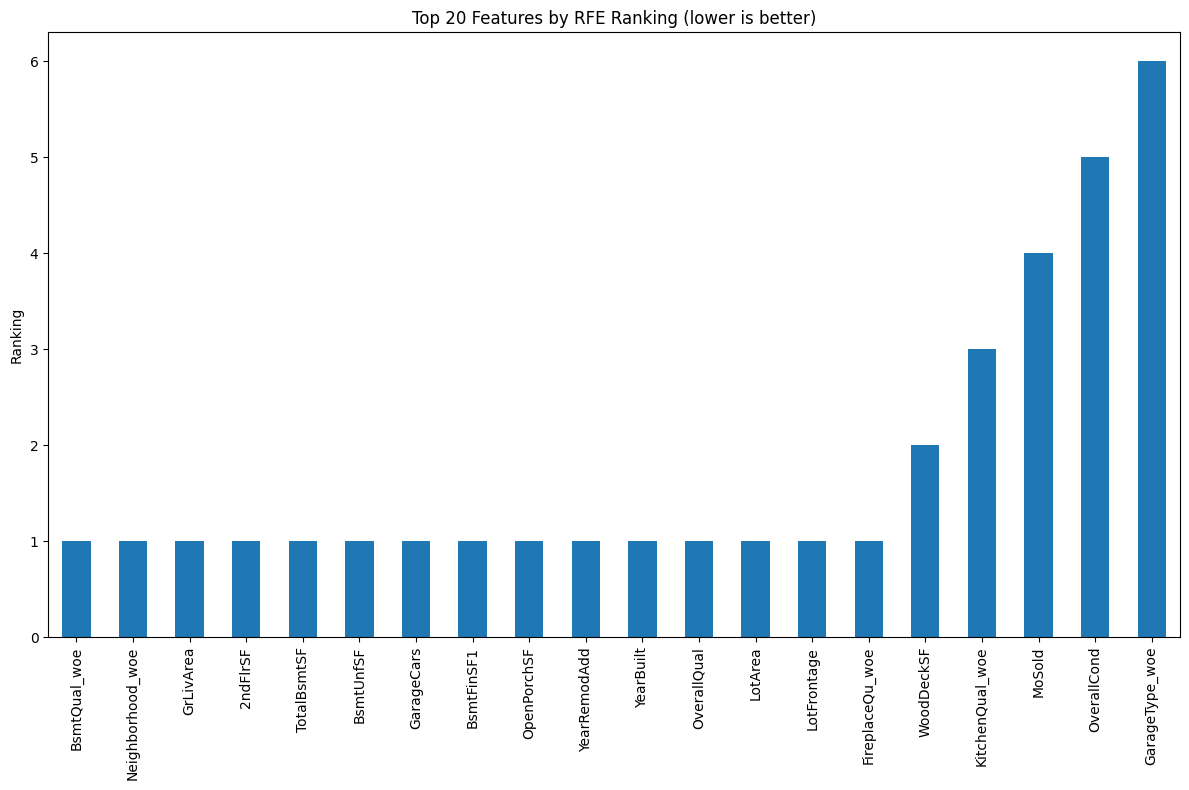

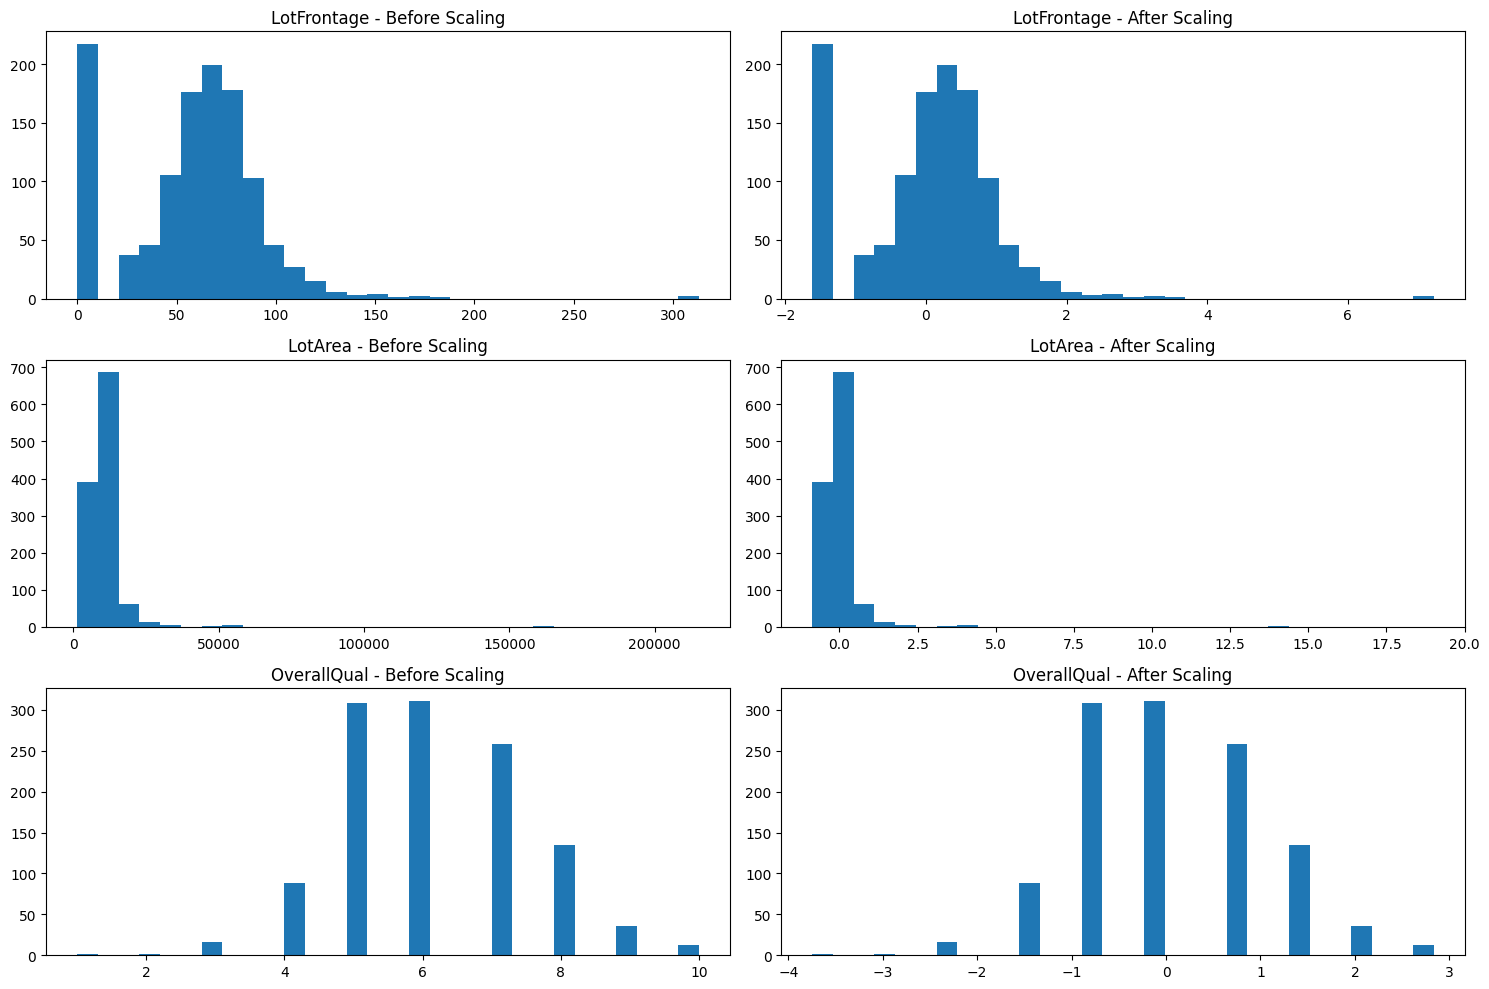

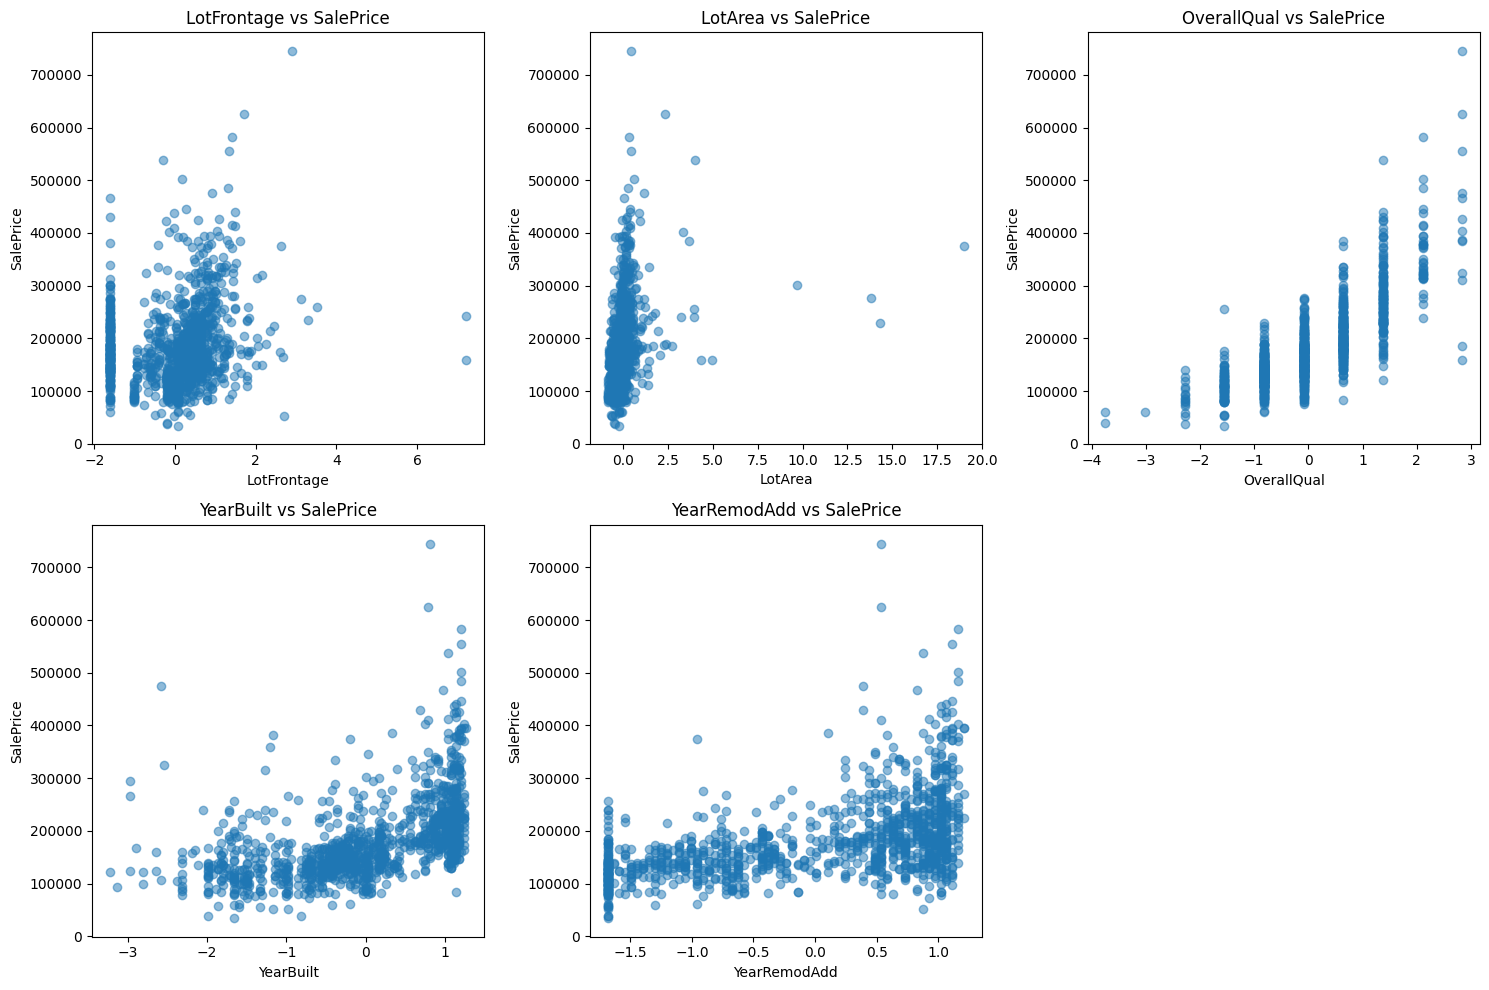

🏃 View run RFE_with_RandomForest at: https://dagshub.com/lkhok22/ML-hw1.mlflow/#/experiments/0/runs/993ab8a023594e158ec33149044d567b
🧪 View experiment at: https://dagshub.com/lkhok22/ML-hw1.mlflow/#/experiments/0


In [703]:
import mlflow
import mlflow.sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Start MLflow run
with mlflow.start_run(run_name="RFE_with_GradientBoosting"):

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_t),
        columns=X_train_t.columns,
        index=X_train_t.index
    )

    # Create and fit the model for feature selection only
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    rfe = RFE(estimator=model, n_features_to_select=15, step=1)
    rfe.fit(X_train_scaled, y_train)

    # Get selected features
    rfe_selected_features = X_train_t.columns[rfe.support_].tolist()
    print("Features selected by RFE:")
    for i, feature in enumerate(rfe_selected_features, 1):
        print(f"{i}. {feature}")

    # Log selected features
    mlflow.log_param("estimator", "GradientBoostingRegressor")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 3)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("n_features_selected", len(rfe_selected_features))
    mlflow.log_text("\n".join(rfe_selected_features), "selected_features.txt")

    # Create directory for plots if it doesn't exist
    os.makedirs("plots", exist_ok=True)

    # Create plot for feature ranking
    feature_ranking = pd.Series(rfe.ranking_, index=X_train_t.columns)
    plt.figure(figsize=(12, 8))
    feature_ranking.sort_values().head(20).plot(kind='bar')
    plt.title('Top 20 Features by RFE Ranking (lower is better)')
    plt.ylabel('Ranking')
    plt.tight_layout()
    ranking_plot_path = "plots/rfe_feature_ranking.png"
    plt.savefig(ranking_plot_path)
    mlflow.log_artifact(ranking_plot_path)

    # Create before/after scaling visualization
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(rfe_selected_features[:3], 1):
        plt.subplot(3, 2, 2*i-1)
        plt.hist(X_train_t[feature], bins=30)
        plt.title(f'{feature} - Before Scaling')

        plt.subplot(3, 2, 2*i)
        plt.hist(X_train_scaled[feature], bins=30)
        plt.title(f'{feature} - After Scaling')

    plt.tight_layout()
    scaling_plot_path = "plots/scaling_visualization.png"
    plt.savefig(scaling_plot_path)
    mlflow.log_artifact(scaling_plot_path)

    # Create scatter plots of features vs. target
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(rfe_selected_features[:5], 1):
        plt.subplot(2, 3, i)
        plt.scatter(X_train_scaled[feature], y_train, alpha=0.5)
        plt.title(f'{feature} vs SalePrice')
        plt.xlabel(feature)
        plt.ylabel('SalePrice')

    plt.tight_layout()
    scatter_plot_path = "plots/feature_distributions.png"
    plt.savefig(scatter_plot_path)
    mlflow.log_artifact(scatter_plot_path)

    # Log the fitted RFE model
    mlflow.sklearn.log_model(rfe, "rfe_model")

    # Show plots if in interactive mode
    plt.show()


In [704]:
from sklearn.base import BaseEstimator, TransformerMixin

class FinalCustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, woe_columns, one_hot_columns, final_columns):
        self.woe_columns = woe_columns # Columns Which Should Be Preprocessed Using WOE
        self.one_hot_columns = one_hot_columns # Columns Which Should Be Preprocessed Using One Hot Encoder

        self.final_columns = final_columns # Columns Selected By RFE

    def fit(self, X, y):
        # Generate Fill Na Values Just in Case
        self.woe_columns_fill_na = X[woe_columns].mode().T[0].to_dict()
        
        df_woe = X.copy()
        target_col = 'target'
        df_woe[target_col] = y

        woe_mappings = {}
        iv_values = {}
        
        for col in self.woe_columns:
            print(f"Processing {col}...")
            
            groups = df_woe.groupby([col])[target_col].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
            
            groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
            groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()
            
            groups['woe'] = np.log(groups['prop_pos'] / groups['prop_neg'])
            groups['iv'] = (groups['prop_pos'] - groups['prop_neg']) * groups['woe']
            
            groups.replace([np.inf, -np.inf], 0, inplace=True)
            groups.fillna(0, inplace=True)
            
            woe_dict = groups['woe'].to_dict()
            iv = groups['iv'].sum()
            
            woe_mappings[col] = woe_dict
            iv_values[col] = iv

        self.woe_mappings = woe_mappings
        self.iv_values = iv_values

        return self


    def transform(self, X):
        X_transformed = X.copy()

        # Preprocess WOE Columns
        print("***")
        print("Preprocessing WOE Columns")
        for col in self.woe_columns:
            X_transformed[f'{col}_woe'] = X_transformed[col].map(self.woe_mappings[col])
            X_transformed.drop(columns=col, inplace=True)

        print("Preprocessing One Hot Columns")
        X_transformed = pd.get_dummies(X_transformed, columns=self.one_hot_columns, drop_first=True, dummy_na=True, dtype=int)

        print("Check Nans")
        n = X_transformed.isna().mean()

        na_cols = list(n[n > 0].index)

        print(na_cols)

        for col in na_cols:
            name, pr = col.split("_")
            if pr != "woe":
                print("Error Related to Nans")

            dic = self.woe_columns_fill_na
            mappings = self.woe_mappings
            X_transformed[col] = X_transformed[col].fillna(mappings[name][dic[name]])

            print(col, name, pr, dic[name], mappings[name][dic[name]])
            
        return X_transformed[self.final_columns]

In [705]:
woe_columns, one_hot_columns, rfe_selected_features

(['MSZoning',
  'LotShape',
  'LandContour',
  'LotConfig',
  'Neighborhood',
  'Condition1',
  'Condition2',
  'BldgType',
  'HouseStyle',
  'RoofStyle',
  'RoofMatl',
  'Exterior1st',
  'Exterior2nd',
  'MasVnrType',
  'ExterQual',
  'ExterCond',
  'Foundation',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'Heating',
  'HeatingQC',
  'Electrical',
  'KitchenQual',
  'Functional',
  'FireplaceQu',
  'GarageType',
  'GarageFinish',
  'GarageQual',
  'GarageCond',
  'SaleType',
  'SaleCondition'],
 ['Street', 'Utilities', 'LandSlope', 'CentralAir', 'PavedDrive'],
 ['LotFrontage',
  'LotArea',
  'OverallQual',
  'YearBuilt',
  'YearRemodAdd',
  'BsmtFinSF1',
  'BsmtUnfSF',
  'TotalBsmtSF',
  '2ndFlrSF',
  'GrLivArea',
  'GarageCars',
  'OpenPorchSF',
  'Neighborhood_woe',
  'BsmtQual_woe',
  'FireplaceQu_woe'])

In [706]:
final_preprocessor = FinalCustomPreprocessor(woe_columns=woe_columns, 
                                             one_hot_columns=one_hot_columns, 
                                             final_columns=rfe_selected_features)

In [707]:
X_train_clean = handle_nulls(X_train)
X_test_clean = handle_nulls(X_test)

In [708]:
# import mlflow
# import mlflow.sklearn
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Define and train the pipeline
# pipeline_lr = Pipeline([
#     ('preprocess', FinalCustomPreprocessor(
#         woe_columns=woe_columns, 
#         one_hot_columns=one_hot_columns, 
#         final_columns=rfe_selected_features)),
#     ('scaler', StandardScaler()),
#     ('model', LinearRegression())
# ])

# with mlflow.start_run(run_name="LinearRegression_Pipeline"):

#     # Fit the model
#     pipeline_lr.fit(X_train_clean, y_train)

#     # Predictions and log-transformation
#     preds_for_evaluation = pipeline_lr.predict(X_test_clean)
#     log_preds = np.log(preds_for_evaluation)
#     log_y_test = np.log(y_test)

#     # Calculate evaluation metrics
#     rmse = np.sqrt(mean_squared_error(log_y_test, log_preds))
#     bias = np.mean(log_preds - log_y_test)
#     variance = np.var(log_preds)

#     # Print metrics
#     print(f"RMSE: {rmse}")
#     print(f"Bias: {bias}")
#     print(f"Variance: {variance}")

#     # Log parameters
#     mlflow.log_param("model", "LinearRegression")
#     mlflow.log_param("scaler", "StandardScaler")
#     mlflow.log_param("preprocessor_type", "FinalCustomPreprocessor")
#     mlflow.log_param("selected_features", len(rfe_selected_features))

#     # Log metrics
#     mlflow.log_metric("rmse", rmse)
#     mlflow.log_metric("bias", bias)
#     mlflow.log_metric("variance", variance)

#     # Log model
#     mlflow.sklearn.log_model(pipeline_lr, "lr_pipeline_model")


In [709]:
# import mlflow
# import mlflow.sklearn
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Start MLflow run
# with mlflow.start_run(run_name="RandomForest_Evaluation"):

#     # Define the pipeline
#     pipeline_rf = Pipeline([
#         ('preprocess', FinalCustomPreprocessor(
#             woe_columns=woe_columns, 
#             one_hot_columns=one_hot_columns, 
#             final_columns=rfe_selected_features)),
#         ('scaler', StandardScaler()),
#         ('model', RandomForestRegressor(random_state=42))
#     ])

#     # Fit the pipeline
#     pipeline_rf.fit(X_train_clean, y_train)

#     # Predict
#     preds_for_evaluation = pipeline_rf.predict(X_test_clean)

#     # Log-transform predictions and true values
#     log_preds = np.log(preds_for_evaluation)
#     log_y_test = np.log(y_test)

#     # Calculate evaluation metrics
#     rmse = np.sqrt(mean_squared_error(log_y_test, log_preds))
#     bias = np.mean(log_preds - log_y_test)
#     variance = np.var(log_preds)

#     # Log model parameters
#     mlflow.log_param("model", "RandomForestRegressor")
#     mlflow.log_param("random_state", 42)
#     mlflow.log_param("n_features_used", len(rfe_selected_features))

#     # Log evaluation metrics
#     mlflow.log_metric("RMSE", rmse)
#     mlflow.log_metric("Bias", bias)
#     mlflow.log_metric("Variance", variance)

#     # Log selected features
#     mlflow.log_text("\n".join(rfe_selected_features), "used_features.txt")

#     # Log the trained pipeline
#     mlflow.sklearn.log_model(pipeline_rf, "model_pipeline")

#     # Output metrics
#     print(f"RMSE: {rmse}")
#     print(f"Bias: {bias}")
#     print(f"Variance: {variance}")


Processing MSZoning...
Processing LotShape...
Processing LandContour...
Processing LotConfig...
Processing Neighborhood...
Processing Condition1...
Processing Condition2...
Processing BldgType...
Processing HouseStyle...
Processing RoofStyle...
Processing RoofMatl...
Processing Exterior1st...
Processing Exterior2nd...
Processing MasVnrType...
Processing ExterQual...
Processing ExterCond...
Processing Foundation...
Processing BsmtQual...
Processing BsmtCond...
Processing BsmtExposure...
Processing BsmtFinType1...
Processing BsmtFinType2...
Processing Heating...
Processing HeatingQC...
Processing Electrical...
Processing KitchenQual...
Processing Functional...
Processing FireplaceQu...
Processing GarageType...
Processing GarageFinish...
Processing GarageQual...
Processing GarageCond...
Processing SaleType...
Processing SaleCondition...
***
Preprocessing WOE Columns
Preprocessing One Hot Columns
Check Nans
[]
***
Preprocessing WOE Columns
Preprocessing One Hot Columns
Check Nans
['RoofMat

2025/04/10 17:21:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RMSE: 0.15315664741839913
Bias: 0.014415280771559317
Variance: 0.1430604591570301
🏃 View run RandomForest_Evaluation at: https://dagshub.com/lkhok22/ML-hw1.mlflow/#/experiments/0/runs/0a59bb80c7de4f329c707d8b09b87841
🧪 View experiment at: https://dagshub.com/lkhok22/ML-hw1.mlflow/#/experiments/0


In [710]:
# import mlflow
# import mlflow.sklearn
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Start MLflow run
# with mlflow.start_run(run_name="XGBoost_Evaluation"):

#     # Define the pipeline with XGBRegressor
#     pipeline_xgb = Pipeline([
#         ('preprocess', FinalCustomPreprocessor(
#             woe_columns=woe_columns, 
#             one_hot_columns=one_hot_columns, 
#             final_columns=rfe_selected_features)),
#         ('scaler', StandardScaler()),
#         ('model', XGBRegressor(random_state=42))
#     ])

#     # Fit the model
#     pipeline_xgb.fit(X_train_clean, y_train)

#     # Make predictions on the test set
#     preds_for_evaluation = pipeline_xgb.predict(X_test_clean)

#     # Log-transform the predictions and actual values
#     log_preds = np.log(preds_for_evaluation)
#     log_y_test = np.log(y_test)

#     # Calculate evaluation metrics
#     rmse = np.sqrt(mean_squared_error(log_y_test, log_preds))
#     bias = np.mean(log_preds - log_y_test)
#     variance = np.var(log_preds)

#     # Log model parameters
#     mlflow.log_param("model", "XGBRegressor")
#     mlflow.log_param("random_state", 42)
#     mlflow.log_param("n_features_used", len(rfe_selected_features))

#     # Log metrics
#     mlflow.log_metric("RMSE", rmse)
#     mlflow.log_metric("Bias", bias)
#     mlflow.log_metric("Variance", variance)

#     # Log selected features
#     mlflow.log_text("\n".join(rfe_selected_features), "used_features.txt")

#     # Log the pipeline model
#     mlflow.sklearn.log_model(pipeline_xgb, "model_pipeline")

#     # Print metrics to console
#     print(f"RMSE: {rmse}")
#     print(f"Bias: {bias}")
#     print(f"Variance: {variance}")


In [711]:
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Start MLflow run
with mlflow.start_run(run_name="GradientBoosting_Evaluation"):

    # Define and fit the pipeline
    pipeline_gb = Pipeline([
        ('preprocess', FinalCustomPreprocessor(
            woe_columns=woe_columns, 
            one_hot_columns=one_hot_columns, 
            final_columns=rfe_selected_features)),
        ('scaler', StandardScaler()),
        ('model', GradientBoostingRegressor(random_state=42))
    ])

    pipeline_gb.fit(X_train_clean, y_train)

    # Make predictions on the test set
    preds_for_evaluation = pipeline_gb.predict(X_test_clean)

    # Log-transform predictions and true values
    log_preds = np.log(preds_for_evaluation)
    log_y_test = np.log(y_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(log_y_test, log_preds))
    bias = np.mean(log_preds - log_y_test)
    variance = np.var(log_preds)

    # Log model and parameters
    mlflow.log_param("model", "GradientBoostingRegressor")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_features_used", len(rfe_selected_features))

    # Log metrics
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("Bias", bias)
    mlflow.log_metric("Variance", variance)

    # Log selected features
    mlflow.log_text("\n".join(rfe_selected_features), "used_features.txt")

    # Log the pipeline model
    mlflow.sklearn.log_model(pipeline_gb, "model_pipeline")

    # Print metrics
    print(f"RMSE: {rmse}")
    print(f"Bias: {bias}")
    print(f"Variance: {variance}")
